# Refinements of a Grocery Store Checkout Operation

In [1]:
!pip install simpy

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import pandas as pd

### Solution 1. 

>The default values for the model are 4 lanes, 1 new customer each minute, up to 25 items per cart, and each checkout server can process 10 items per minute. Rerun the simulation to determine the minimum number of lanes required for a stationary behavior. For this purpose, you may find it useful to extend the simulation from 60 minutes to a longer horizon.

* Increasing the solution horizon to 600 minutes helps detect non-stationary behavior.
* The number of checkout lanes is reduced by changing the value of N. 
    * N = 1 ==> non-stationary behavior evident in the increasing queue lengths
    * N = 2 ==> stationary behavior

The conclusion is that at least 2 checkout lanes are required.

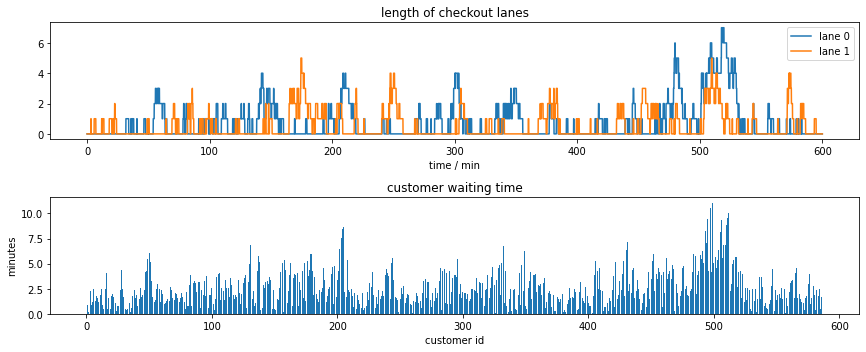

In [7]:
# time units = minutes

# number of checkout lanes
N = 2

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        lane_number = random.randint(0, N-1)
        yield lanes[lane_number].put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create a server for a specified check out lane
def checkout(lane, t_item = 1/10):
    while True:
        customer_id, n_cart_items, enter_time = yield lane.get()
        yield env.timeout(n_cart_items*t_item)
        customer_log.append([customer_id, n_cart_items, enter_time, env.now])
        
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
customer_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator())
env.process(lane_logger())
for n in range(N):
    env.process(checkout(lanes[n]))

# run simulation
env.run(until=600)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "leave"])
customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

# plot results
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)

ax[1].bar(customer_df["customer id"], customer_df["elapsed"])
ax[1].set_xlabel("customer id")
ax[1].set_ylabel("minutes")
ax[1].set_title("customer waiting time")
plt.tight_layout()

### Solution 2. 

>Repeat the first exercise, but this time leave 4 lanes, and determine the maximum rate of customers that can be accommodated with stationary behavior. 

As shown in the following cell, the code was edited to incorporate a parameter `customer_rate` that specifies the rate of customer generation per minute. Setting the simulation horizon to 6000 minutes allowed for a more sensitive determination of stationarity. Some trial and error shows a rate of 2.9 customers per minutes yields a stationary result, a rate of 3.0 is non-stationary.

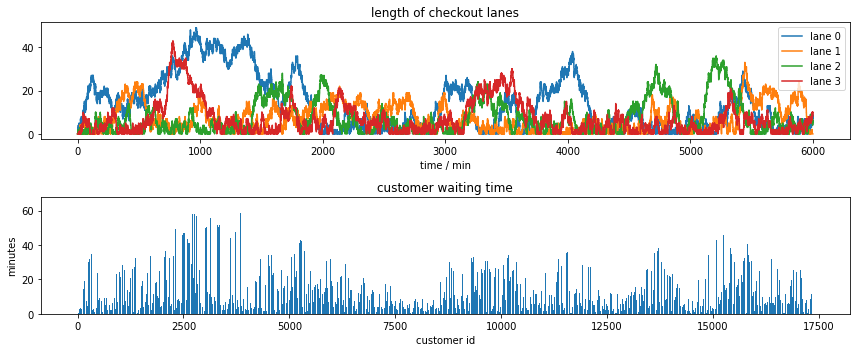

In [25]:
# time units = minutes

# number of checkout lanes
N = 4

# customers / minute
customer_rate = 2.90

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        lane_number = random.randint(0, N-1)
        yield lanes[lane_number].put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create a server for a specified check out lane
def checkout(lane, t_item = 1/10):
    while True:
        customer_id, n_cart_items, enter_time = yield lane.get()
        yield env.timeout(n_cart_items*t_item)
        customer_log.append([customer_id, n_cart_items, enter_time, env.now])
        
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
customer_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator(customer_rate))
env.process(lane_logger())
for n in range(N):
    env.process(checkout(lanes[n]))

# run simulation
env.run(until=6000)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "leave"])
customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

# plot results
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)

ax[1].bar(customer_df["customer id"], customer_df["elapsed"])
ax[1].set_xlabel("customer id")
ax[1].set_ylabel("minutes")
ax[1].set_title("customer waiting time")
plt.tight_layout()

### Solution 3. 

> The time required for at the checkout counter is currently proportional to the number of items in the cart. A more realistic model would also include the additional time required for payment. Add a `t_payment` parameter to the checkout model with a default value of 2 minutes. Incorporate that time into the model. 

The necessary modifications are to add a parameter `t_payment`with a value of 2 minutes. The parameter is incorporated into the `checkout` generator to model the additional time required at the checkout counter.

The net effect is to increase the required number of checkout lanes to 4 or more, and reduce the maximum customer_rate to less than 2.0

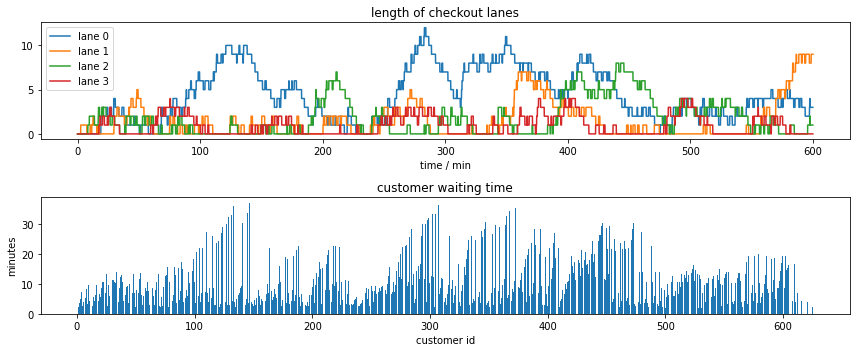

In [34]:
# time units = minutes

# number of checkout lanes
N = 4

# customers / minute
customer_rate = 1.00

# payment period
t_payment = 2.0

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        lane_number = random.randint(0, N-1)
        yield lanes[lane_number].put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create a server for a specified check out lane
def checkout(lane, t_item = 1/10):
    while True:
        customer_id, n_cart_items, enter_time = yield lane.get()
        yield env.timeout(t_payment + n_cart_items*t_item)
        customer_log.append([customer_id, n_cart_items, enter_time, env.now])
        
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
customer_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator(customer_rate))
env.process(lane_logger())
for n in range(N):
    env.process(checkout(lanes[n]))

# run simulation
env.run(until=600)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "leave"])
customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

# plot results
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)

ax[1].bar(customer_df["customer id"], customer_df["elapsed"])
ax[1].set_xlabel("customer id")
ax[1].set_ylabel("minutes")
ax[1].set_title("customer waiting time")
plt.tight_layout()

### Solution 4. 

>In the current model, are assumed to randomly select a lane. A more realistic behavior is for customers to select the shortest lane. Modify `customer_generator` to assign to the customer to the shortest lane. For this, you will need to access the length of each lane. For example, `len(lanes[0].items)` will return the length of lane 0.

As originally written, `customer_generator` randomly assign each new customer to a checkout lane. This is now rewritten to find the lane with the fewest customers. In the case of a tie, the lane with the lowest index is chosen. Here is a comparison of the relevant lines of code. Note that the minimum could be found in a number of ways, this one being particularly 'pythonic'.

    lane = lanes[random.randint(0, N-1)]   # <== random lane
    lane = min(lanes, key=lambda lane: len(lane.items))  # <== shortest lane


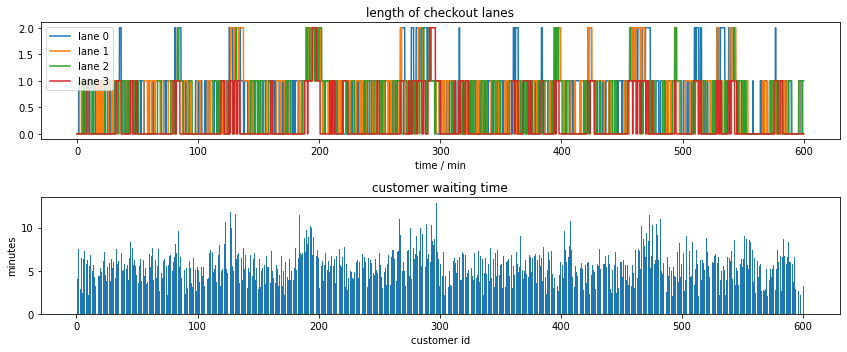

In [43]:
# time units = minutes

# number of checkout lanes
N = 4

# customers / minute
customer_rate = 1.00

# payment period
t_payment = 2.0

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        #lane = lanes[random.randint(0, N-1)]
        lane = min(lanes, key=lambda lane: len(lane.items))
        yield lane.put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create a server for a specified check out lane
def checkout(lane, t_item = 1/10):
    while True:
        customer_id, n_cart_items, enter_time = yield lane.get()
        yield env.timeout(t_payment + n_cart_items*t_item)
        customer_log.append([customer_id, n_cart_items, enter_time, env.now])
        
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
customer_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator(customer_rate))
env.process(lane_logger())
for n in range(N):
    env.process(checkout(lanes[n]))

# run simulation
env.run(until=600)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "leave"])
customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

# plot results
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)

ax[1].bar(customer_df["customer id"], customer_df["elapsed"])
ax[1].set_xlabel("customer id")
ax[1].set_ylabel("minutes")
ax[1].set_title("customer waiting time")
plt.tight_layout()

### Solution 5. 

>The current plots report the total amount from when a customer enters the lane to the time the customer leaves the checkout. But what customers really care about is the time spent waiting to get to the checkout. Modify the customer data logging to collect the waiting time, construct a plot of the waiting time for each customer, and report the averate waiting time and length of each queue.

All of these changes improve the data collection and reporting. Several code changes are required:

* The `checkout` generator is modified to compute `wait_time` at the point a customer has been retrieved from the associated queue, and the data is added to `customer_log`.
* The Pandas dataframe `customer_df` is modified to incorporate a waiting time column.
* An additional plot for waiting time is added, and the original plot title changed to the more accurate  total elapsed time.
* Additional code is added to compute the key performance indicaators
    

Average waiting time =  2.94 minutes

Average lane queue 
lane 0    1.158833
lane 1    0.918000
lane 2    0.647333
lane 3    0.482500
dtype: float64

Overall aaverage lane queue 
0.8017


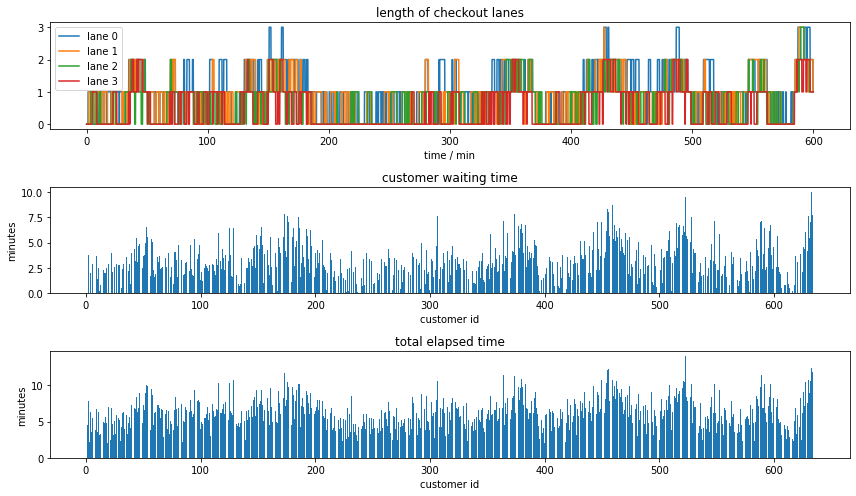

In [70]:
# time units = minutes

# number of checkout lanes
N = 4

# customers / minute
customer_rate = 1.00

# payment period
t_payment = 2.0

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        #lane = lanes[random.randint(0, N-1)]
        lane = min(lanes, key=lambda lane: len(lane.items))
        yield lane.put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create a server for a specified check out lane
def checkout(lane, t_item = 1/10):
    while True:
        customer_id, n_cart_items, enter_time = yield lane.get()
        wait_time = env.now - enter_time
        yield env.timeout(t_payment + n_cart_items*t_item)
        customer_log.append([customer_id, n_cart_items, enter_time, wait_time, env.now])
        
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
customer_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator(customer_rate))
env.process(lane_logger())
for n in range(N):
    env.process(checkout(lanes[n]))

# run simulation
env.run(until=600)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "wait", "leave"])
customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

# compute kpi's
print(f"Average waiting time = {customer_df['wait'].mean():5.2f} minutes")
print(f"\nAverage lane queue \n{lane_df.mean()}")
print(f"\nOverall aaverage lane queue \n{lane_df.mean().mean():5.4f}")

# plot results
fig, ax = plt.subplots(3, 1, figsize=(12, 7))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)

ax[1].bar(customer_df["customer id"], customer_df["wait"])
ax[1].set_xlabel("customer id")
ax[1].set_ylabel("minutes")
ax[1].set_title("customer waiting time")

ax[2].bar(customer_df["customer id"], customer_df["elapsed"])
ax[2].set_xlabel("customer id")
ax[2].set_ylabel("minutes")
ax[2].set_title("total elapsed time")
plt.tight_layout()

### Solution 6. 

>Someone has suggested changing two of the lanes to self-checkout. But a side effect of self-checkout is to increase the amount of time required to scan each item in a cart. Suppose the scan time goes from 6 seconds to 12 seconds for typical, untrained customers. Will additional attended lanes be required to offset the effect of slower scanning in the self-checkout lanes? If so, how many additional lanes will be required?

The prior cell ('Solution 5') provides a base case against which to measure the effects of the proposed changes. The changes are implemented by creating processes for the self-serve and the attended check out lanes.

    # self-serve lanes
    env.process(checkout(lanes[0], t_item=1/5))
    env.process(checkout(lanes[1], t_item=1/5))

    # attended lanes
    for n in range(2, N):
        env.process(checkout(lanes[n]))

With just a total of four lanes, the slower checkout on the self-serve lines increases average waiting time from approximately 3 minutes to 10 minutes, and the average queue length from about 1 to about 3. Adding an additional attended lane recovers the original system performance.

Average waiting time =  2.88 minutes

Average lane queue 
lane 0    0.976000
lane 1    0.807333
lane 2    0.576333
lane 3    0.386167
lane 4    0.180667
dtype: float64

Overall aaverage lane queue 
0.5853


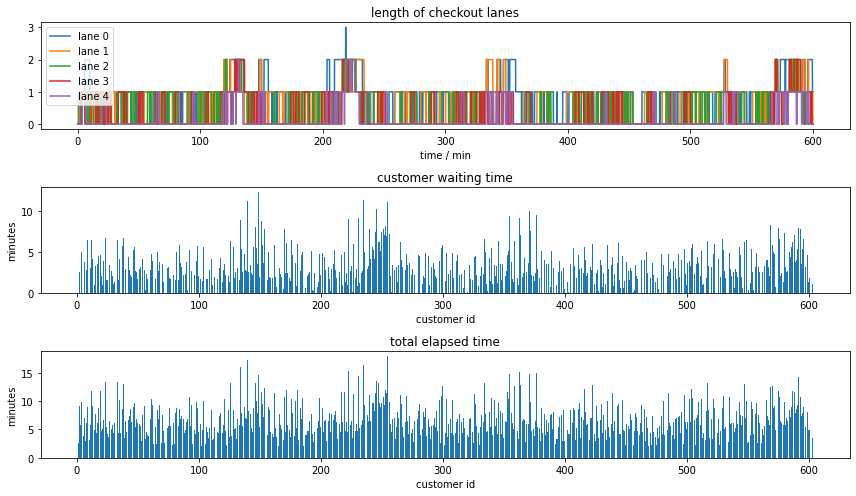

In [89]:
# time units = minutes

# number of checkout lanes
N = 5

# customers / minute
customer_rate = 1.00

# payment period
t_payment = 2.0

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        lane = min(lanes, key=lambda lane: len(lane.items))
        yield lane.put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create a server for a specified check out lane
def checkout(lane, t_item = 1/10):
    while True:
        customer_id, n_cart_items, enter_time = yield lane.get()
        wait_time = env.now - enter_time
        yield env.timeout(t_payment + n_cart_items*t_item)
        customer_log.append([customer_id, n_cart_items, enter_time, wait_time, env.now])
        
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
customer_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator(customer_rate))
env.process(lane_logger())

# self-serve lanes
env.process(checkout(lanes[0], t_item=1/5))
env.process(checkout(lanes[1], t_item=1/5))

# attended lanes
for n in range(2, N):
    env.process(checkout(lanes[n]))

# run simulation
env.run(until=600)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "wait", "leave"])
customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

# compute kpi's
print(f"Average waiting time = {customer_df['wait'].mean():5.2f} minutes")
print(f"\nAverage lane queue \n{lane_df.mean()}")
print(f"\nOverall aaverage lane queue \n{lane_df.mean().mean():5.4f}")

# plot results
fig, ax = plt.subplots(3, 1, figsize=(12, 7))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)

ax[1].bar(customer_df["customer id"], customer_df["wait"])
ax[1].set_xlabel("customer id")
ax[1].set_ylabel("minutes")
ax[1].set_title("customer waiting time")

ax[2].bar(customer_df["customer id"], customer_df["elapsed"])
ax[2].set_xlabel("customer id")
ax[2].set_ylabel("minutes")
ax[2].set_title("total elapsed time")
plt.tight_layout()

### Solution 7. 

>Suppose we were to change one or more of the lanes to a express lanes which handle only with a small number of items, say five or fewer. How would you expect this to change average waiting time? This is a form of prioritization ... are there other prioritizations that you might consider?


Average waiting time =  3.53 minutes

Average lane queue 
lane 0    1.207500
lane 1    1.027000
lane 2    0.024333
lane 3    0.684500
lane 4    0.462000
dtype: float64

Overall aaverage lane queue 
0.6811


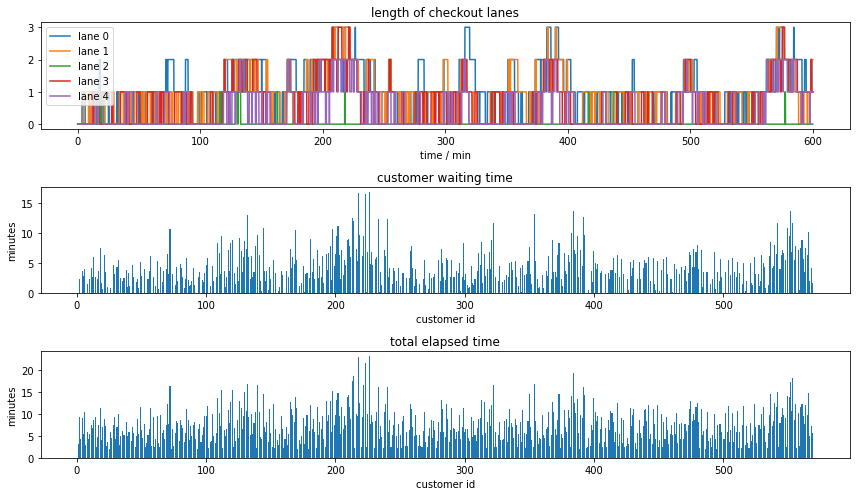

In [3]:
# time units = minutes

# number of checkout lanes
lane_capacity = [25, 25, 5, 25, 25]
N = len(lane_capacity)

# customers / minute
customer_rate = 1.00

# payment period
t_payment = 2.0

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        lanes_with_capacity = [lanes[n] for (n, lane) in enumerate(lanes) if n_cart_items <= lane_capacity[n]]
        lane = min(lanes_with_capacity, key=lambda lane: len(lane.items))
        yield lane.put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create a server for a specified check out lane
def checkout(lane, t_item = 1/10, item_limit=25):
    lane.item_limit = item_limit
    while True:
        customer_id, n_cart_items, enter_time = yield lane.get()
        wait_time = env.now - enter_time
        yield env.timeout(t_payment + n_cart_items*t_item)
        customer_log.append([customer_id, n_cart_items, enter_time, wait_time, env.now])
        
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
customer_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator(customer_rate))
env.process(lane_logger())

# self-serve lanes
env.process(checkout(lanes[0], t_item=1/5))
env.process(checkout(lanes[1], t_item=1/5))

# attended lanes
for n in range(2, N):
    env.process(checkout(lanes[n]))

# run simulation
env.run(until=600)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "wait", "leave"])
customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

# compute kpi's
print(f"Average waiting time = {customer_df['wait'].mean():5.2f} minutes")
print(f"\nAverage lane queue \n{lane_df.mean()}")
print(f"\nOverall aaverage lane queue \n{lane_df.mean().mean():5.4f}")

# plot results
fig, ax = plt.subplots(3, 1, figsize=(12, 7))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)

ax[1].bar(customer_df["customer id"], customer_df["wait"])
ax[1].set_xlabel("customer id")
ax[1].set_ylabel("minutes")
ax[1].set_title("customer waiting time")

ax[2].bar(customer_df["customer id"], customer_df["elapsed"])
ax[2].set_xlabel("customer id")
ax[2].set_ylabel("minutes")
ax[2].set_title("total elapsed time")
plt.tight_layout()